[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/group_timeseries_split.ipynb)

# 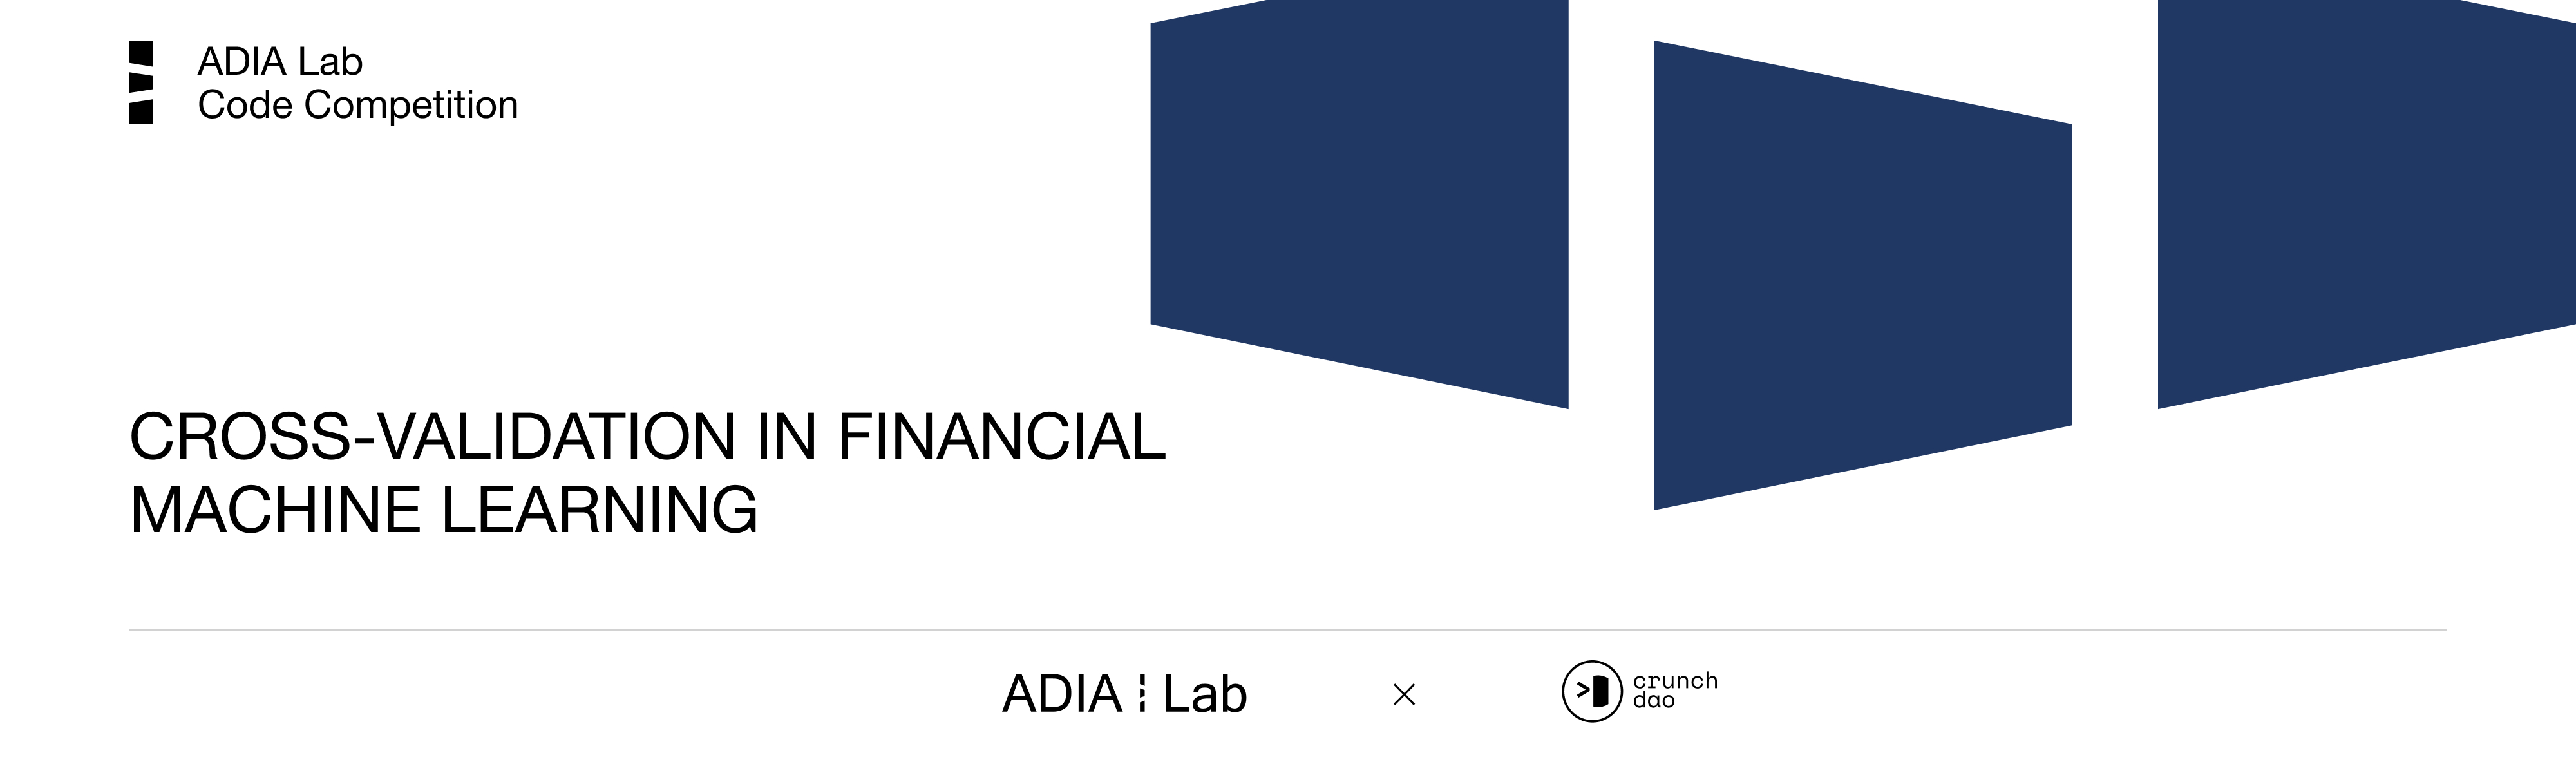

# Cross-Validation in Financial Machine Learning

The purpose of this notebook is twofold:

- Firstly, we outline the need for Time Series Cross Validation in the field of Financial Machine Learning;
- we test the mlxtend scikit-learn-compatible [GroupTimesSeriesSplit](https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) on the ADIA Lab Market Prediction Competition dataset.

## The need for Time Series Cross Validation in Financial Machine Learning 

Tabular time series cross-validation is a specialized technique used in machine learning and data analysis to evaluate the performance of predictive models on time series data organized in a tabular format. Unlike traditional cross-validation methods that randomly split the data into training and testing sets, tabular time series cross-validation takes into account the temporal ordering of the data. 

The importance of tabular time series cross-validation arises from the unique characteristics of time series data, where the order and timing of observations are crucial. In many real-world applications, such as finance, economics, and weather forecasting, the historical patterns and trends in the data play a significant role in making accurate predictions for the future. Traditional cross-validation methods may not be suitable for evaluating time series models as they can lead to data leakage and unrealistic performance estimates.

## Cross Validation in the ADIA Lab Market Prediction Competition

### Overview

This notebook focuses on GroupTimeSeriesSplit from mlxtend, one of the most complete, already existing module dealing with time series cross validation.

GroupTimeSeriesSplit is a scikit-learn-compatible time series cross-validator that supports non-overlapping groups. Time series tasks in machine learning require special types of validation, because the time order of the objects is important for a fairer evaluation of an ML model’s quality.
Also, there can be different time units for splitting the data for different tasks - hours, days, months, ...

This validator can be flexibly configured via a number of input parameters:

- test_size : integer, represents the size of test set;
- train_size : integer, represents the size of train set;
- n_splits : integer, represents the number of splits;
- gap_size : integer, represents the gap size between train and test sets;
- shift_size : integer, represents the step to shift for the next fold;
- window_type : string, represents the type of window used for the splits.

See the [full documentation](https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) for more details.

### Implementation

Below, we should a Cross Validation quickstarted on the ADIA Lab Market Prediction Competition dataset. In this section, the goal is to explain how GroupTimeSeriesSplit works.

In [1]:
# import necessary libraries and dependendies from mlxtend
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit, # GroupTimeSeriesSplit is the actual validator class
    plot_splits, # plot_splits is a command to plot the folds
    print_cv_info, # print_cv_info prints informations about the cross validation
    print_split_info, # print_split_info prints informations about the folds (data and data indices inside the folds)
)

In [2]:
# other libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.linear_model import LinearRegression
from scipy.stats import norm

### Loading the data

Let's take a look at the data. The data is from the first phase of ADIA Lab market prediction competition.

In [ ]:
!pip3 install crunch-cli --upgrade

In [ ]:
# import and instantiante the crunch package in this notebook
import crunch
crunch = crunch.load_notebook(__name__)

In [ ]:
!crunch --notebook setup curly-cedric --token dNC6peKScPoVCTssI27DJ8zzRHpLtu7otHINZa0uv5T12MiYjvWcYAnNJ27XkkHI
%cd curly-cedric

In [ ]:
# Getting the data
X, y, _ = crunch.load_data()

Let's merge X and y to have the complete dataset.

In [4]:
df = X.merge(y, on=['date', 'id'], how='inner')

In [5]:
df.head()

,date,id,0,1,2,3,4,5,6,7,...,452,453,454,455,456,457,458,459,460,y
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,...,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385,0.192308
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,...,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180,-0.476959
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,...,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585,0.080645
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,...,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590,0.953125
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,...,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992,-0.979263


First, let's plot the number of observations for each date in the dataset. We want to make sure that there are enough observations in each cross section so that each fold contains enough data.

<Axes: xlabel='date'>

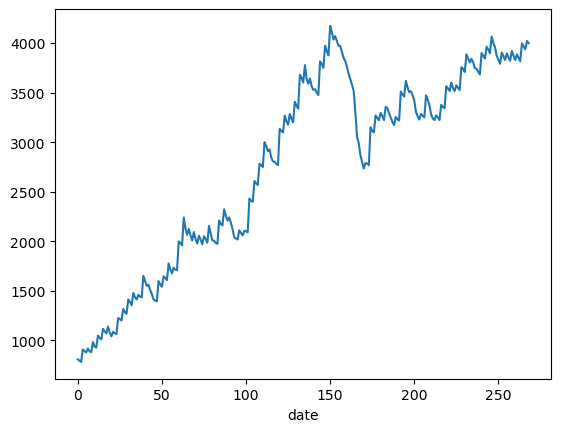

In [6]:
df.groupby('date')['id'].count().plot()

The minimum number of observations is approximately equal to 500 and is reached for the first date. Moreover the number of observations shows an overall increasing trend. So there should be no folds containing very little data.

Let's say we want to split the data into five folds, in an expanding window fashion.

A mandatory parameter that GroupTimeSeriesSplit expect is test_size. The test_size will be set to 30 meaning that it will contain 30 dates which is the number of dates over which the models are scored during the first phase of the ADIA Lab market prediction competition.

Another important parameter to specify is called *groups*. This is the parameter on which GroupTimesSeriesSplit will perform the split. For the split to take place correctly, *groups* must correspond to the column in the dataframe used as time unit. For ADIA Lab dataset, *groups* will be the column *date*.

In [7]:
features = df.columns.drop(['y'])
target = ['date', 'id', 'y']

cv_args = {'test_size':30, 'n_splits': 5, 'window_type': 'expanding'}
CV = GroupTimeSeriesSplit(**cv_args)

groups = df['date'].values

for train_index, val_index in tqdm(CV.split(df, groups=groups)):
    train_set = df.iloc[train_index]
    val_set = df.iloc[val_index]
    X_train, y_train = train_set[features], train_set[target]
    X_val, y_val = val_set[features], val_set[target]

0it [00:00, ?it/s]

For the sake of readability, we will only print the features of the 5th fold.

In [8]:
X_train.head()

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,...,-0.731349,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,...,0.610428,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,...,0.212365,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,...,1.254787,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,...,-2.007721,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992


In [9]:
X_val.head()

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
625794,239,8f23588e5f0a61e4f6b94e387620491642795b35acb505...,0.871230,-1.749740,-1.540548,1.455000,-0.796636,1.591933,-0.282753,1.308714,...,-0.512887,-2.771143,1.405152,-0.616428,-0.561600,0.473722,0.368620,-0.330042,1.424442,0.920225
625795,239,f811c4e0867787f20b1f5cd9691e7a67321ef0dcb29142...,0.766324,-0.826822,-0.104257,-0.169196,1.587045,0.109717,1.241321,-0.371143,...,1.471874,-0.680765,-1.522002,0.260640,2.631520,1.886525,0.301562,2.245249,0.783134,1.560713
625796,239,a7254f7c97becb90330a6d0cf8f5108614368986c7728f...,-0.829611,-0.723908,-0.444992,0.721015,-0.039129,-1.209471,1.058201,0.711135,...,-0.640887,0.709859,0.046172,0.957191,0.377711,-0.566726,0.689737,0.442061,-0.748585,-0.230464
625797,239,192784e441653700afb02550b623b3a03ceb013d1c0ab6...,-0.698725,1.406884,-0.488685,1.455004,1.094333,0.714405,0.436183,-1.291147,...,-0.331882,-0.866963,0.489252,-0.417336,0.096085,-1.491831,0.889478,-0.045876,-0.264853,0.537618
625798,239,99fd3d733482515108f1e17828b0f0ca27880e42090884...,2.667356,-0.313013,0.436718,-1.225039,-1.593033,-1.124582,-0.982088,0.626054,...,0.904938,-0.078596,1.109387,-1.765085,-2.181217,-1.557834,-0.927909,0.568477,-0.161956,-1.297535


In [10]:
X_train['date'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
X_val['date'].unique()

array([239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268])

In [12]:
X_val['date'].unique().shape

(30,)

We can see that the training and validation set are not overlapping. The validation set effectively contains 30 dates as specfied by the parameters *n_splits*.

Now let's say we want to set an embargo between the train and validation sets. Embargo is the number of time units you should eliminate from the training
set observations that immediately follow an observation in the validation set. This concept is represented on the following figure.

<div style="text-align:center">
    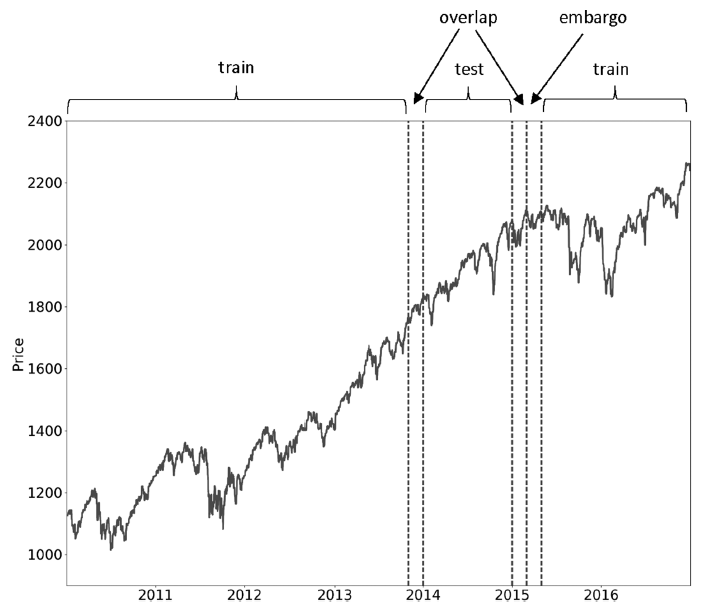
</div>



The embargo value is controlled by the parameter called *gap_size* which is an integer, here set to 1.

In [13]:
features = df.columns.drop(['y'])
target = ['date', 'id', 'y']

cv_args = {'test_size':30, 'n_splits': 5, 'window_type': 'expanding', 'gap_size':1}
CV = GroupTimeSeriesSplit(**cv_args)

groups = df['date'].values

for train_index, val_index in tqdm(CV.split(df, groups=groups)):
    train_set = df.iloc[train_index]
    val_set = df.iloc[val_index]
    X_train, y_train = train_set[features], train_set[target]
    X_val, y_val = val_set[features], val_set[target]

0it [00:00, ?it/s]

Let's print the features of the 5th fold. 

In [14]:
X_train.head()

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,...,-0.731349,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,...,0.610428,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,...,0.212365,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,...,1.254787,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,...,-2.007721,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992


In [15]:
X_val.head()

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
625794,239,8f23588e5f0a61e4f6b94e387620491642795b35acb505...,0.871230,-1.749740,-1.540548,1.455000,-0.796636,1.591933,-0.282753,1.308714,...,-0.512887,-2.771143,1.405152,-0.616428,-0.561600,0.473722,0.368620,-0.330042,1.424442,0.920225
625795,239,f811c4e0867787f20b1f5cd9691e7a67321ef0dcb29142...,0.766324,-0.826822,-0.104257,-0.169196,1.587045,0.109717,1.241321,-0.371143,...,1.471874,-0.680765,-1.522002,0.260640,2.631520,1.886525,0.301562,2.245249,0.783134,1.560713
625796,239,a7254f7c97becb90330a6d0cf8f5108614368986c7728f...,-0.829611,-0.723908,-0.444992,0.721015,-0.039129,-1.209471,1.058201,0.711135,...,-0.640887,0.709859,0.046172,0.957191,0.377711,-0.566726,0.689737,0.442061,-0.748585,-0.230464
625797,239,192784e441653700afb02550b623b3a03ceb013d1c0ab6...,-0.698725,1.406884,-0.488685,1.455004,1.094333,0.714405,0.436183,-1.291147,...,-0.331882,-0.866963,0.489252,-0.417336,0.096085,-1.491831,0.889478,-0.045876,-0.264853,0.537618
625798,239,99fd3d733482515108f1e17828b0f0ca27880e42090884...,2.667356,-0.313013,0.436718,-1.225039,-1.593033,-1.124582,-0.982088,0.626054,...,0.904938,-0.078596,1.109387,-1.765085,-2.181217,-1.557834,-0.927909,0.568477,-0.161956,-1.297535


In [16]:
X_train['date'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [17]:
X_val['date'].unique()

array([239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268])

In [18]:
X_val['date'].unique().shape

(30,)

We can see that the split is correctly done. There is indeed an embargo of 1 time unit between the train and the validation set. We can also notice that the validaton set still contains 30 dates, as required.

### Application of GroupTimeSeriesSplit in Supervised Learning

In this section, we will use GroupTimeSeriesSplit to perform Cross Validation on the ADIA Lab Market Prediction Competition data.

The model to generate the predictions is described as follows:
- preprocessing: as we are using a linear model with an mse loss function, models benefit from data being identically distributed: data are cross-sectionally Gaussianised.
- modeling: we perform a linear regression using scikit-learn for the training and the inference.

The performance of our model will nevertheless be assessed using the spearman rank correlation.

#### Preprocessing step

In [19]:
def gaussianise_df(x):
    nstocks = x.shape[0]
    x0 = np.linspace(-3, 3, nstocks)
    cdf_vector = norm.cdf(x0)
    xx = np.linspace(cdf_vector[0], cdf_vector[-1], nstocks)
    gx = norm.ppf(xx)
    gauss_xc = np.empty_like(gx)
    for c in x.columns[2:]:
        indices = np.argsort(x[c].values)
        gauss_xc[indices] = gx
        x[c] = gauss_xc
    return x

In [20]:
gauss_df = df.groupby('date', group_keys=False).progress_apply(lambda x: gaussianise_df(x))

  0%|          | 0/269 [00:00<?, ?it/s]

Let's compare the data before and after the transformation. The choice of the plotted features is purely random.

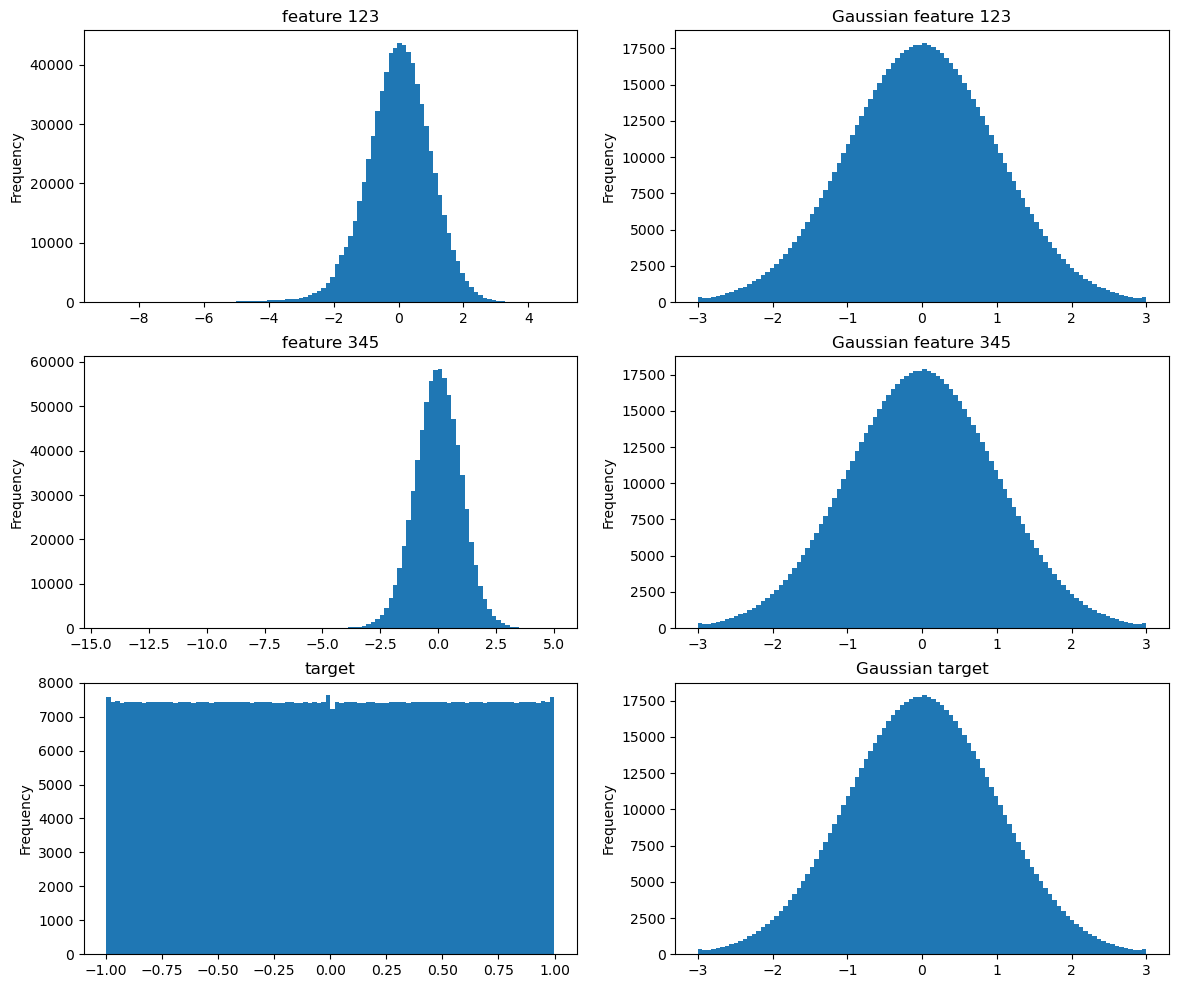

In [21]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

df['123'].plot(kind='hist', bins=100, ax=ax1, title='feature 123')
gauss_df['123'].plot(kind='hist', bins=100, ax=ax2, title='Gaussian feature 123')
df['345'].plot(kind='hist', bins=100, ax=ax3, title='feature 345')
gauss_df['345'].plot(kind='hist', bins=100, ax=ax4, title='Gaussian feature 345')
df['y'].plot(kind='hist', bins=100, ax=ax5, title='target')
gauss_df['y'].plot(kind='hist', bins=100, ax=ax6, title='Gaussian target')

fig.show()

#### Prediction step
The following function takes as an input the predictions of the target, the actual target, val_refs which contains the *date* and *id* columns of the validation sets. It returns the spearman rank correlation for each date.

In [22]:
def get_spearman_results(preds, y_test, val_refs):
    preds.rename({f'{target}':f'pred_{target}' for target in preds.columns}, axis=1, inplace=True)
    preds_ref = pd.concat([preds.reset_index(drop=True), val_refs.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    spearman = pd.DataFrame()
    
    target_suffixes = [col.split('_')[-1] for col in preds_ref.columns if 'pred' in col]
    for suffix in target_suffixes:
        spearman[f'target_{suffix}'] = preds_ref.groupby('date')[[f'pred_{suffix}', f'{suffix}']].corr(method='spearman').unstack().iloc[:,1]

    return spearman

The following function defines the linear model that we use to predict the target. It takes as input X_train, y_train, X_val, y_val, val_refs and the target. It returns the average spearman rank correlation over the validation set.

In [23]:
def linear_model(X_train, y_train, X_val, y_val, val_refs, target):
    model = LinearRegression(n_jobs=10, positive=False)
    model.fit(X_train, y_train[target])
    preds = pd.DataFrame(model.predict(X_val), columns=[target])
    spearman_results = get_spearman_results(preds, y_val, val_refs)

    return spearman_results.mean().values

The following function sets up the cross validation. It takes as input the arguments of GroupTimeSeriesSplit, the dataset, the features and the target. It returns the spearman rank correlation for each fold.

In [37]:
def cross_validation(cv_args, df, features, target):
    val_score = []
    cross_validator = GroupTimeSeriesSplit(**cv_args)
    groups = df['date'].values
    
    # creating the folds
    for train_index, val_index in tqdm(cross_validator.split(df, groups=groups)):
        train_set = df.iloc[train_index]
        val_set = df.iloc[val_index]
        X_train, y_train = train_set[features], train_set[target]
        X_val, y_val = val_set[features], val_set[target]
        train_refs = train_set.iloc[:, :2]
        val_refs = val_set.iloc[:, :2]

        # training and validation steps
        spearman_score = linear_model(X_train, y_train, X_val, y_val, val_refs, 'y')
        val_score.append(spearman_score*100)
    return val_score

We are going to run the cross validation in a expanding window fashion with 5 splits, a test size of 30 (meaning that the test size will contain 30 dates) and an embargo of 1. Shift size is set to 30. The shift size is the number of skipped time unit between each fold.

In [25]:
cv_args = {'test_size':30, 'n_splits': 5, 'window_type': 'expanding', 'gap_size': 1, 'shift_size':30}
features = df.columns.drop(['date', 'id', 'y'])
target = ['y']

exp_val_score = cross_validation(cv_args, gauss_df, features, target)

0it [00:00, ?it/s]

The folds are represented on the following plot.

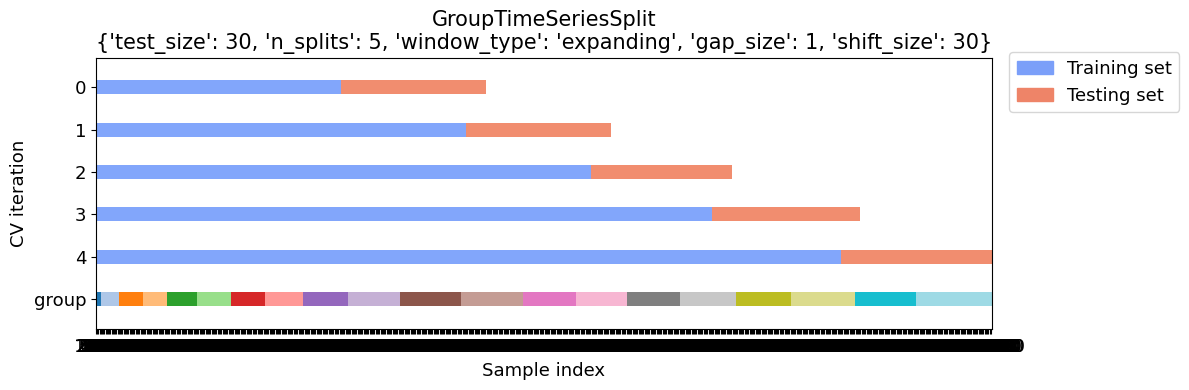

In [26]:
plot_splits(X, y, groups, **cv_args)

The mean of the spearman rank correlation for each fold is plotted in the following Figure:

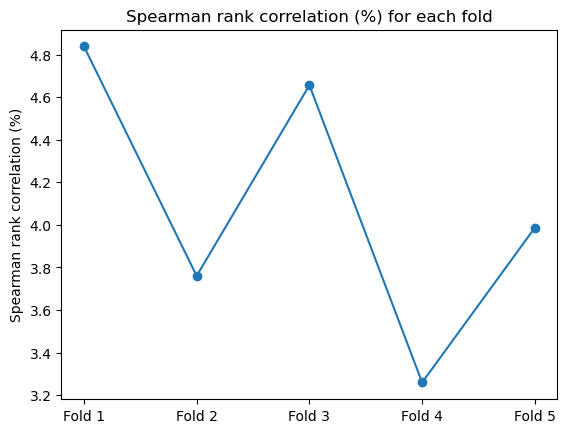

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

n_split = len(exp_val_score)
x = [i for i in range(1, n_split+1)]
xticks = ['Fold {}'.format(i) for i in range(1, n_split+1)]
ax.plot(x, exp_val_score, '-o')
ax.set_xticks(x, xticks)
ax.set_title('Spearman rank correlation (%) for each fold')
ax.set_ylabel('Spearman rank correlation (%)')
fig.show()

In [36]:
print("The spearman rank correlation mean over the folds is equal to {:.2f}".format(np.mean(exp_val_score)))

The spearman rank correlation mean over the folds is equal to 4.10


The results obtained are quite good for such a simple model that does not take into account non-linearities.

### Rolling window
Let's see if the window type have an influence on the performance of the model. We are going to run the cross validation in a rolling window fashion with 5 splits, a test size of 30 (meaning that the test size will contain 30 dates) and an embargo of 1. The shift size is set to 30.

In [30]:
cv_args = {'test_size':30, 'n_splits': 5, 'window_type':'rolling', 'gap_size': 1, 'shift_size':30}
features = df.columns.drop(['date', 'id', 'y'])
target = ['y']

roll_val_score = cross_validation(cv_args, gauss_df, features, target)

0it [00:00, ?it/s]

The folds are represented on the following plot.

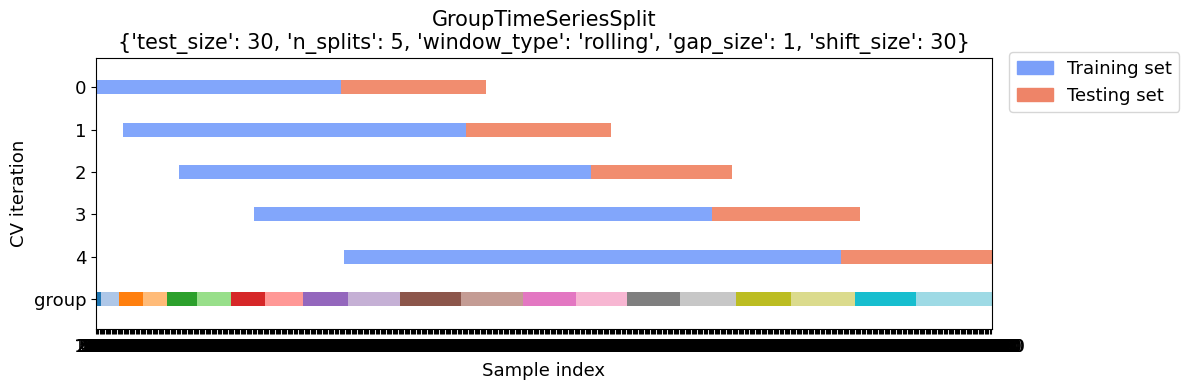

In [31]:
plot_splits(X, y, groups, **cv_args)

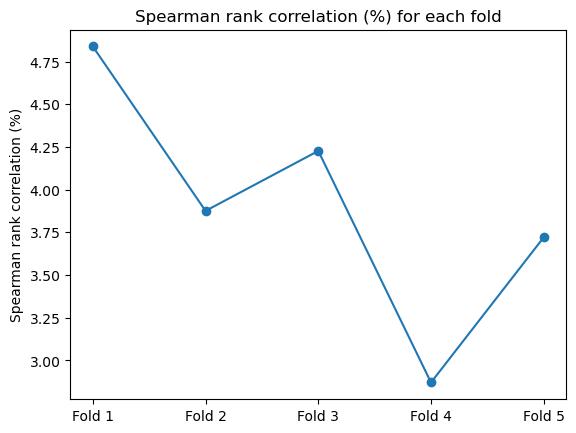

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

n_split = len(roll_val_score)
x = [i for i in range(1, n_split+1)]
xticks = ['Fold {}'.format(i) for i in range(1, n_split+1)]
ax.plot(x, roll_val_score, '-o')
ax.set_xticks(x, xticks)
ax.set_title('Spearman rank correlation (%) for each fold')
ax.set_ylabel('Spearman rank correlation (%)')
fig.show()

In [35]:
print("The spearman rank correlation mean over the folds is equal to {:.2f}".format(np.mean(roll_val_score)))

The spearman rank correlation mean over the folds is equal to 3.91


We can see that the results obtained with a rolling window are worse than the ones with an expanding window.

## Conclusion

The purpose of this notebook is to demonstrate the need for a time series cross validator in Financial Machine Learning and to show how to apply it via an already existing library: GroupTimeSeriesSplit.

GroupTimeSeriesSplit is an interesting module from mlxtend that already possesses relevant features for Financial Machine Learning Cross-Validation:
- window_type : a parameter allowing the user to select between expanding and rolling window;
- gap_size : a parameter that represents the notion of embargo.

## References
[1] López de Prado, Marcos. Advances in Financial Machine Learning. Wiley, 2018.

[2] GroupTimeSeriesSplit: A scikit-learn compatible version of the time series validation with groups, mlxtend.
https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/. Last visited, 17th July 2023.